### Exploring dataset

In [2]:
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
%matplotlib inline

file_human = 'training_data/human/human_00000.wav'
file_spoof = 'training_data/spoof/spoof_00000.wav'

waveform_human, sample_human = torchaudio.load(file_human)
waveform_spoof, sample_spoof = torchaudio.load(file_spoof)

print(f'Shape of human waveform: {waveform_human.size()}')
print(f'Sample rate of human waveform: {sample_human}')
print('')
print(f'Shape of spoof waveform: {waveform_spoof.size()}')
print(f'Sample rate of spoof waveform: {sample_spoof}')

Shape of human waveform: torch.Size([1, 78240])
Sample rate of human waveform: 16000

Shape of spoof waveform: torch.Size([1, 72480])
Sample rate of spoof waveform: 16000


In [2]:
torchaudio.get_audio_backend()

'soundfile'

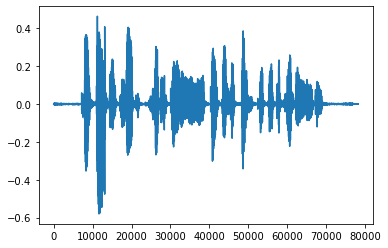

In [3]:
plt.figure()
plt.plot(waveform_human.t().numpy())

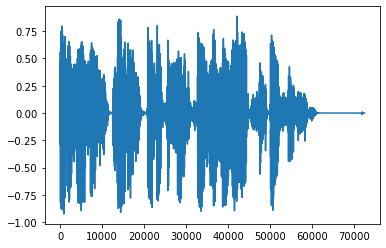

In [4]:
plt.figure()
plt.plot(waveform_spoof.t().numpy())

Shape of human spec: torch.Size([1, 201, 392])


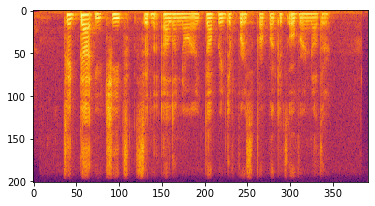

In [5]:
specgram_human = torchaudio.transforms.Spectrogram()(waveform_human)

print(f'Shape of human spec: {specgram_human.size()}')

plt.figure()
plt.imshow(specgram_human.log2()[0, :, :].detach().numpy(), cmap = 'inferno')
plt.savefig('human1.png')

Shape of spoof spec: torch.Size([1, 201, 363])


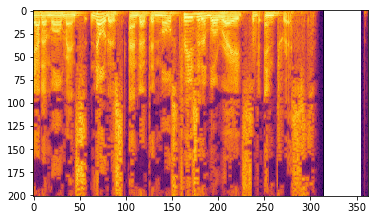

In [6]:
specgram_spoof = torchaudio.transforms.Spectrogram()(waveform_spoof)

print(f'Shape of spoof spec: {specgram_spoof.size()}')

plt.figure()
plt.imshow(specgram_spoof.log2()[0, :, :].detach().numpy(), cmap = 'inferno')
plt.savefig('spoof1.png')

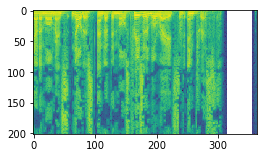

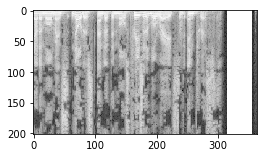

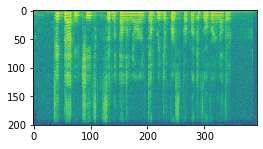

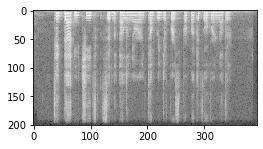

In [3]:
specgram_spoof = torchaudio.transforms.Spectrogram()(waveform_spoof)
specgram_human = torchaudio.transforms.Spectrogram()(waveform_human)
plt.figure(figsize=(4,4))
plt.imshow(specgram_spoof.log2()[0, :, :].detach().numpy(), cmap = 'viridis')
plt.figure(figsize=(4,4))
plt.imshow(specgram_spoof.log2()[0, :, :].detach().numpy(), cmap = 'gray')
plt.figure(figsize=(4,4))
plt.imshow(specgram_human.log2()[0, :, :].detach().numpy(), cmap = 'viridis')
plt.figure(figsize=(4,4))
plt.imshow(specgram_human.log2()[0, :, :].detach().numpy(), cmap = 'gray')

Shape of spoof spec: torch.Size([1, 201, 363])


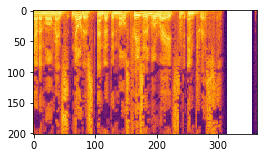

In [7]:
specgram_spoof = torchaudio.transforms.Spectrogram()(waveform_spoof)

print(f'Shape of spoof spec: {specgram_spoof.size()}')

plt.figure(figsize=(4,4))
plt.imshow(specgram_spoof.log2()[0, :, :].detach().numpy(), cmap = 'inferno')
plt.savefig("spoof", dpi=56)

### Transform spectrograms to images

In [16]:
from pathlib import Path
from glob import glob

def spec_to_image(path_to_files, save_path):
    for i, file in enumerate(Path(path_to_files).glob('*.wav')):
        waveform, _ = torchaudio.load(file)
        specgram = torchaudio.transforms.Spectrogram()(waveform)
        plt.figure(figsize=(4,4))
        plt.imshow(specgram.log2()[0, :, :].detach().numpy(), cmap = 'inferno')
        plt.savefig(save_path + str(i), dpi = 56)
        plt.clf()

In [ ]:
spec_to_image('testing_data', 'test/image')
spec_to_image('training_data', 'train/human/human')
spec_to_image('training_data', 'train/spoof/spoof')

In [27]:
for i, file in enumerate(Path('train/human').glob('*.png')):
    if i % 10 == 0:
        file.replace(Path('valid/human') / file.name)  

In [28]:
for i, file in enumerate(Path('train/spoof').glob('*.png')):
    if i % 10 == 0:
        file.replace(Path('valid/spoof') / file.name)  

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets

### Transforms and loaders

In [2]:
train_dir = 'train/'
valid_dir = 'valid/'
random_transforms = [transforms.RandomAffine(45), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip()]
train_transforms = transforms.Compose([transforms.RandomRotation(90),
                                       transforms.RandomChoice(random_transforms),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

def loaders(dir_list, transforms_list, batch_size, num_workers, shuffle = True):
    #оборачиваю создание загрузчиков в фунцию для удобства
    train_dataset = datasets.ImageFolder(dir_list[0], transform = transforms_list[0])
    valid_dataset = datasets.ImageFolder(dir_list[1], transform = transforms_list[1])
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)
    loaders = {'train': trainloader, 'valid': validloader}
    return loaders

loaders = loaders(['train/', 'valid/'],[train_transforms, train_transforms] , 32, 0, True)

In [31]:
hidden_dim = 2048
out = 2
classifier = nn.Linear(hidden_dim, out)
use_cuda = torch.cuda.is_available()

In [33]:
model = models.resnet50(pretrained = True)
model.fc = classifier
weights = torch.tensor([9289 / 44999, 35710 / 44999], dtype=torch.float, device='cuda:0')
criterion = nn.CrossEntropyLoss(weight = weights)
optimizer = optim.SGD(model.parameters(), lr = 0.005, momentum = 0.85)
if use_cuda:
    print('Cuda is available!')
    model = model.cuda()

Cuda is available!


### Training

In [34]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    control_dict = {} #словарь контрольных значений ошибки для дальнейшей визуализации
    valid_loss_min = np.Inf #стартовый порог ошибки валидации для дальнейшего сохранения модели
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):#тренировка
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):#валидация
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
        train_loss = train_loss / len(loaders['train'])
        valid_loss = valid_loss / len(loaders['valid'])
        print(f'Epoch: {epoch}\tTraining Loss: {train_loss}\tValidation Loss: {valid_loss}')
        #сохраняем модель если ошибка валидации уменьшилась
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min} --> {valid_loss})')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        control_dict[epoch] = [train_loss, valid_loss]
        #возвращаем обученную модель и словарь контрольных значений
    return model, control_dict

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
#функция для визуализации данных
def visualize(data):
    visual_data = np.array(list(data.values()))
    ax = np.arange(len(data)) 
    y_train = visual_data[:, 0] 
    y_valid = visual_data[:, 1]
    plt.plot(ax, y_train, label = 'train loss')
    plt.plot(ax, y_valid, label = 'valid loss')
    plt.title('Training and validation')
    plt.legend()
    plt.show()

In [36]:
trained_model, visual_data = train(100, loaders, model, optimizer, criterion, use_cuda, 'resnet50.pt')

Epoch: 1	Training Loss: 3.981256297857692	Validation Loss: 2.3064071289293326
Validation loss decreased (inf --> 2.3064071289293326)
Epoch: 2	Training Loss: 2.2062285757321116	Validation Loss: 2.7595210578411247
Epoch: 3	Training Loss: 1.7838744017445796	Validation Loss: 1.1652259826185598
Validation loss decreased (2.3064071289293326 --> 1.1652259826185598)
Epoch: 4	Training Loss: 1.4848711483925845	Validation Loss: 1.7169555388628297
Epoch: 5	Training Loss: 1.361427949062352	Validation Loss: 0.9878354695845087
Validation loss decreased (1.1652259826185598 --> 0.9878354695845087)
Epoch: 6	Training Loss: 1.2206082577572561	Validation Loss: 0.9730178763864527
Validation loss decreased (0.9878354695845087 --> 0.9730178763864527)
Epoch: 7	Training Loss: 1.180006949920088	Validation Loss: 0.9174808482847111
Validation loss decreased (0.9730178763864527 --> 0.9174808482847111)
Epoch: 8	Training Loss: 1.0481084529585163	Validation Loss: 1.031058878857334
Epoch: 9	Training Loss: 1.05957761154

Epoch: 91	Training Loss: 0.1310827362203723	Validation Loss: 0.7094669029674308
Epoch: 92	Training Loss: 0.14398016535332794	Validation Loss: 0.6943043620945918
Epoch: 93	Training Loss: 0.13849732763213068	Validation Loss: 0.5501784073072025
Epoch: 94	Training Loss: 0.14636184111340414	Validation Loss: 0.6473015813371835
Epoch: 95	Training Loss: 0.11196857869338729	Validation Loss: 0.8057384736821752
Epoch: 96	Training Loss: 0.12215558780090995	Validation Loss: 1.077026911321114
Epoch: 97	Training Loss: 0.15939770296593875	Validation Loss: 0.6693531008848155
Epoch: 98	Training Loss: 0.11827669052461053	Validation Loss: 0.7613046467291239
Epoch: 99	Training Loss: 0.12583825694278816	Validation Loss: 0.6901397181851964
Epoch: 100	Training Loss: 0.1019748739883631	Validation Loss: 0.7440550596568576


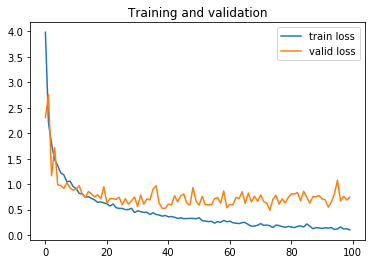

In [37]:
visualize(visual_data)

In [3]:
from PIL import Image
from PIL import ImageFile
import pandas as pd

train_dataset = datasets.ImageFolder(train_dir, transform = train_transforms)
class_names = train_dataset.classes
print(class_names)

['human', 'spoof']


In [4]:
hidden_dim = 2048
out = 2
classifier = nn.Linear(hidden_dim, out)
resnet50 = models.resnet50(pretrained = True)
resnet50.fc = classifier
resnet50.load_state_dict(torch.load('resnet50.pt'))

<All keys matched successfully>

In [5]:
resnet50.class_to_idx = train_dataset.class_to_idx

### Predicting labels

In [8]:
def process_image(image):
    #трансформитуем изображение для нейронной сети
    resizing = transforms.Compose([transforms.Resize(255),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
    result = resizing(image)
    return np.array(result)

def predict(image_path, model, topk=2):
    #функция для предсказания результатов
    device = torch.device("cuda")
    model.to(device)
    model.eval()
    
    img_open = Image.open(image_path).convert('RGB') 
    img_processed = process_image(img_open)
    img_torch = torch.from_numpy(img_processed)
    
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float().cuda()
    
    with torch.no_grad():
        output = model.forward(img_torch)
        
    probability = F.softmax(output.data.cpu(),dim=1)
    
    probs = np.array(probability.topk(topk)[0][0])
    
    index_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_classes = [np.str(index_to_class[each]) for each in np.array(probability.topk(topk)[1][0])]
    
    return probs, top_classes

In [9]:
probs, classes = predict('valid/human/human0.png', resnet50)
print(probs)
print(classes)

[9.9999356e-01 6.3957318e-06]
['human', 'spoof']


In [10]:
columns = ['file_name', 'human_prob']
test_audio = pd.DataFrame(columns = columns)
test_audio

,file_name,human_prob


### From Dataframe to csv

In [11]:
from pathlib import Path
for i, file in enumerate(Path('test').glob('*.png')):
    probs, classes = predict('test/' + file.name, resnet50)
    test_audio.loc[i] = [file.name[:11] + '.wav'] + [probs[classes.index('human')]]

In [12]:
print(test_audio.head())
test_audio.to_csv('test_audio', index = False)

         file_name    human_prob
0  sample_0000.wav  8.170944e-01
1  sample_0001.wav  1.275788e-09
2  sample_0002.wav  9.942124e-01
3  sample_0003.wav  3.543585e-05
4  sample_0004.wav  9.999981e-01
